In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import msgpack as mp
import msgpack_numpy as mpn
import os
import sys
import cv2
# directory reach
directory = os.path.abspath('')
append_path = os.path.dirname(directory) # go two folders up
from pykinect2 import PyKinectRuntime
from pykinect2 import PyKinectV2

kinectColor = PyKinectRuntime.PyKinectRuntime(PyKinectV2.FrameSourceTypes_Color)

  
# setting path
sys.path.append(append_path)
from cv2 import aruco

from support.pd_support import *
from support.calculations_support import *
from support.generate_ar_data import get_ar_pose_data

In [ ]:
while True:
    if kinectColor.has_new_color_frame():
        color_frame = kinectColor.get_last_color_frame()
        color_frame = np.reshape(color_frame, (1080, 1920, 4))
        color_frame = cv2.flip(color_frame, 1)
        break

In [5]:
_pth = r"C:\Users\CMC\Dropbox\mira\mira_vellore\splitVideos\SUJIXXXXXXXXU010120000000XXXXXXXXX\calibration"

calib_pth = os.path.join(_pth, "AR_CALIBRATION.msgpack")
_calib_file = open(calib_pth, "rb")
unpacker = mp.Unpacker(_calib_file, object_hook=mpn.decode)
_calib = []
for unpacked in unpacker:
    _calib.append(unpacked)

cameraMatrix = _calib[0][0]
distCoeffs = _calib[0][1]




In [8]:
_data_pth = r"C:\Users\CMC\Dropbox\mira\mira_vellore\splitVideos\SUJIXXXXXXXXU010120000000XXXXXXXXX\test_trial_0"
df = get_ar_pose_data(_data_pth, cameraMatrix, distCoeffs, process_raw=True)

returning dataframe


In [9]:
df

,frame_id,x,y,z,yaw,pitch,roll
0,5.0,-0.043325,2.073002,20.779583,-0.051006,2.972120,0.625188
1,5.0,-0.043325,2.073002,20.779583,-0.051006,2.972120,0.625188
2,5.0,-0.043325,2.073002,20.779583,-0.051006,2.972120,0.625188
3,5.0,-0.043325,2.073002,20.779583,-0.051006,2.972120,0.625188
4,5.0,-0.049073,2.089439,21.002592,-0.034814,2.975741,0.560238
...,...,...,...,...,...,...,...
608,5.0,-0.963801,1.816900,21.152631,-0.072193,2.988333,0.666742
609,5.0,-0.983677,1.853618,21.589610,-0.104655,3.006473,0.531793
610,5.0,-0.963801,1.816900,21.152631,-0.072193,2.988333,0.666742
611,5.0,-0.963801,1.816900,21.152631,-0.072193,2.988333,0.666742


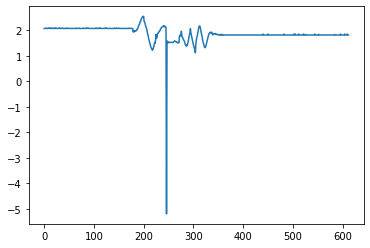

In [14]:
plt.plot(df['y'])